In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from collections import deque

%matplotlib inline

Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def load_data():
 # Loading + training,validation test split
    cars0 = glob.glob('Car_dataset/vehicles/GTI_Far/*.png')
    cars1 = glob.glob('Car_dataset/vehicles/GTI_MiddleClose/*.png')
    cars2 = glob.glob('Car_dataset/vehicles/GTI_Left/*.png')
    cars3 = glob.glob('Car_dataset/vehicles/GTI_Right/*.png')
    cars4 = glob.glob('Car_dataset/vehicles/KITTI_extracted/*.png')
    #cars4 += glob.glob('./vehicles/augmentation/*.png')
    notcars1 = glob.glob('Car_dataset/non-vehicles/Extras/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/GTI/*.png')

    # split 70% training 20% validation 10% test set
    frac1 = 0.7
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L1 = (frac1*np.array([l0,l1,l2,l3,l4,l5])).astype('int')
    frac2 = 0.9
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L2 = (frac2*np.array([l0,l1,l2,l3,l4,l5])).astype('int')

    cars_train = cars0[:L1[0]] + cars1[:L1[1]] + cars2[:L1[2]] + cars3[:L1[3]] + cars4[:L1[4]]
    notcars_train = notcars1[:L1[5]]

    cars_val = cars0[L1[0]:L2[0]] + cars1[L1[1]:L2[1]] + cars2[L1[2]:L2[2]] + cars3[L1[3]:L2[3]] + cars4[L1[4]:L2[4]]
    notcars_val = notcars1[L1[5]:L2[5]]

    cars_test = cars0[L2[0]:] + cars1[L2[1]:] + cars2[L2[2]:] + cars3[L2[3]:] + cars4[L2[4]:]
    notcars_test = notcars1[L2[5]:]
    
    return cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test

In [3]:
cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test = load_data()

cars_train_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_train)):
    cars_train[i] = mpimg.imread(cars_train[i])
cars_train_4d = np.stack(cars_train,axis=0)

cars_test_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_test)):
    cars_test[i] = mpimg.imread(cars_test[i])
cars_test_4d = np.stack(cars_test,axis=0)

cars_val_4d = np.zeros(shape=(64,64,3))
for i in range (len(cars_val)):
    cars_val[i] = mpimg.imread(cars_val[i])
cars_val_4d = np.stack(cars_val,axis=0)

notcars_val_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_val)):
    notcars_val[i] = mpimg.imread(notcars_val[i])
notcars_val_4d = np.stack(notcars_val,axis=0)

notcars_train_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_train)):
    notcars_train[i] = mpimg.imread(notcars_train[i])
notcars_train_4d = np.stack(notcars_train,axis=0)

notcars_test_4d = np.zeros(shape=(64,64,3))
for i in range (len(notcars_test)):
    notcars_test[i] = mpimg.imread(notcars_test[i])
notcars_test_4d = np.stack(notcars_test,axis=0)

print("shapes of arrays:", cars_train_4d.shape, notcars_train_4d.shape, cars_val_4d.shape, notcars_val_4d.shape, cars_test_4d.shape, notcars_test_4d.shape)

shapes of arrays: (6152, 64, 64, 3) (6277, 64, 64, 3) (1759, 64, 64, 3) (1794, 64, 64, 3) (881, 64, 64, 3) (897, 64, 64, 3)


In [4]:
#Create an array stack of feature vectors
X_train = np.vstack((cars_train_4d, notcars_train_4d))
X_val = np.vstack((cars_val_4d, notcars_val_4d))
X_test = np.vstack((cars_test_4d, notcars_test_4d))
y_train = np.hstack((np.ones(len(cars_train_4d)),np.zeros(len(notcars_train_4d))))
y_val = np.hstack((np.ones(len(cars_val_4d)),np.zeros(len(notcars_val_4d))))
y_test = np.hstack((np.ones(len(cars_test_4d)),np.zeros(len(notcars_test_4d))))

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(12429, 64, 64, 3) (3553, 64, 64, 3) (1778, 64, 64, 3) (12429,) (3553,) (1778,)


In [31]:
# Initializing the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu', padding='same'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#gather history info
history = classifier.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=32, epochs=7, verbose=1)

# list all data in history
print(history.history.keys())

Train on 12429 samples, validate on 3553 samples
Epoch 1/7
12429/12429 [==============================] - 56s 5ms/step - loss: 0.1748 - acc: 0.9319 - val_loss: 0.1473 - val_acc: 0.9476
Epoch 2/7
12429/12429 [==============================] - 55s 4ms/step - loss: 0.0491 - acc: 0.9829 - val_loss: 0.0371 - val_acc: 0.9882
Epoch 3/7
12429/12429 [==============================] - 52s 4ms/step - loss: 0.0260 - acc: 0.9910 - val_loss: 0.0304 - val_acc: 0.9890
Epoch 4/7
12429/12429 [==============================] - 56s 5ms/step - loss: 0.0198 - acc: 0.9928 - val_loss: 0.0281 - val_acc: 0.9885
Epoch 5/7
12429/12429 [==============================] - 55s 4ms/step - loss: 0.0169 - acc: 0.9942 - val_loss: 0.0987 - val_acc: 0.9696
Epoch 6/7
12429/12429 [==============================] - 52s 4ms/step - loss: 0.0206 - acc: 0.9934 - val_loss: 0.0409 - val_acc: 0.9848
Epoch 7/7
12429/12429 [==============================] - 52s 4ms/step - loss: 0.0114 - acc: 0.9962 - val_loss: 0.0574 - val_acc: 0.9803

7


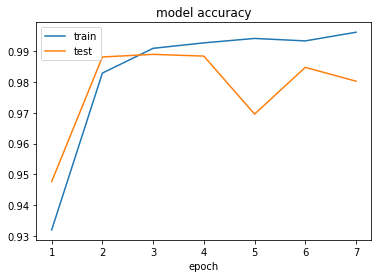

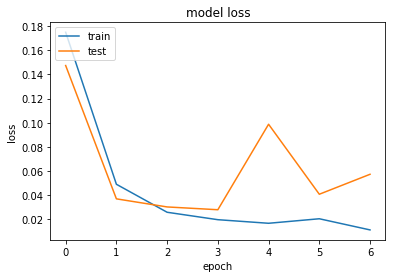

In [32]:
%matplotlib inline
# summarize history for accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)
print(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The test image is a: car


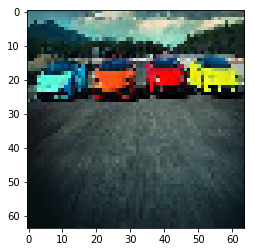

In [42]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('Car_dataset_CNN/visualtestex/lambos.jpeg', target_size = (64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'car'
else:
    prediction = 'non-car'

print("The test image is a:",prediction)

In [34]:
#import test set of 1280x720 images to run classifier on 64x64 sliding windows
cars_frame_test_path = glob.glob('CarND-Vehicle-Detection/test_images/*')
#cars_frame_test_4d = np.zeros(shape=(64,64,3))
#for i in range (len(cars_frame_test)):
cars_frame_test = mpimg.imread(cars_frame_test_path[7])
cars_frame_test_4d = np.expand_dims(cars_frame_test, axis = 0)
#cars_frame_test_4d = np.stack(cars_frame_test,axis=0)
print("Verify shape of test frames: ",cars_frame_test_4d.shape)

Verify shape of test frames:  (1, 720, 1280, 3)


In [35]:
def draw_box(img, bboxes, color=(255,0,0), thickness=6):
    cpyimg = np.copy(img)
    random_color=False;
    for bbox in bboxes:
        if color=='random'or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        #Draw box using opencv
        cv2.rectangle(cpyimg, bbox[0], bbox[1], color, thickness)
        
    #return manipulated image with box
    return cpyimg

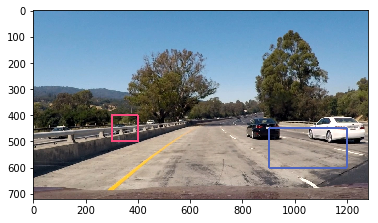

In [36]:
# Test box drawing on sample test_frame image
bboxes = [((300,400),(400,500)),((900,450),(1200,600))]
box_test_image = mpimg.imread(cars_frame_test_path[7])
result = draw_box(box_test_image, bboxes, color='random')
plt.imshow(result)

In [39]:
# Calculate how many 64x64 grid squares are in the image
rows = cars_frame_test_4d.shape[1]/64
cols = cars_frame_test_4d.shape[2]/64
rows = int(rows)
cols = int(cols)
print(rows,cols)
# define the amount of overlap between grid cells
OVERLAP = 0.5
grid_rows = int((rows-1)/(1-OVERLAP))+1
grid_cols = int((cols-1)/(1-OVERLAP))+1

print("Image has",(rows, cols),"blocks of 64 pixels, with overlap",OVERLAP,"grid_size =",(grid_rows, grid_cols))


11 20
Image has (11, 20) blocks of 64 pixels, with overlap 0.5 grid_size = (21, 39)


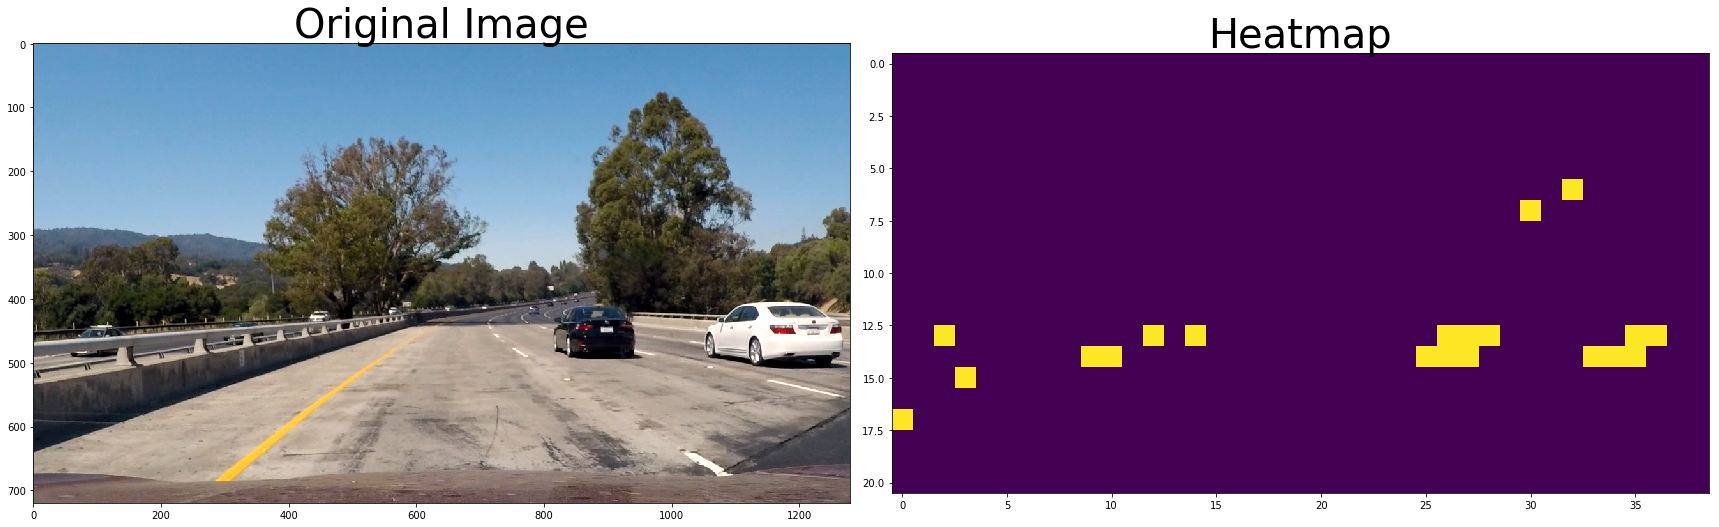

Total inference time sliding window with overlap: 50.0 % took 1.6764280796051025 seconds


In [40]:
# Initialize an empty array for the detections
detections = np.zeros((grid_rows,grid_cols))
x=[]
y=[]
# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,grid_rows):
    for j in range(0,grid_cols):
        start_col = j*64*(1-OVERLAP)
        start_col = int(start_col)
        start_row = i*64*(1-OVERLAP)
        start_row = int(start_row)
        grid_square = cars_frame_test_4d[:,start_row:start_row+64, start_col:start_col+64]
        # make prediction
        prediction = classifier.predict([grid_square])
        detections[i,j] = np.amax(prediction[0])
        if detections[i,j]>0.9:
            x.append(i)
            y.append(j)
end = time.time()
        
#Print image before heatmap and display the predicted class for each grid square

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cars_frame_test)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(detections)
ax2.set_title('Heatmap', fontsize=40)
plt.show()

#plt.imshow(result)
# Display total time to perform inference
print('Total inference time sliding window with overlap:',(OVERLAP*100),'% took',(end-start),'seconds')

In [15]:
#Print heatmap car detection coordinates
for i in range(len(x)): 
    print(x[i],y[i])

4 30
6 32
7 30
8 25
11 25
11 30
12 7
12 22
12 34
13 2
13 26
13 27
13 28
13 35
13 36
13 37
14 3
14 26
14 27
14 28
14 33
14 34
15 35
17 0
